Memasukkan Library yang dibutuhkan

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    # The %tensorflow_version magic only works in colab.
    %tensorflow_version 2.x
except Exception:
    pass
import numpy as np
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
print(tf.__version__)

2.15.0


Mengimport Dataset

In [4]:
# Mengekstrak File Zip
import zipfile # tambahkan library agar bisa ekstrak zip
local_zip = 'Data.zip'
extract_zip = zipfile.ZipFile(local_zip, 'r')
extract_zip.extractall('')
extract_zip.close()

In [5]:
!ls Data/image
!ls Data/image/train
!ls Data/image/train/Panu
!ls Data/image/train/Kadas
!ls Data/image/train/Kudis

test  train
Kadas  Kudis  Panu
'Panu (10).jpg'  'Panu (19).jpg'  'Panu (27).jpg'  'Panu (35).jpg'  'Panu (4).jpg'
'Panu (11).jpg'  'Panu (1).jpg'   'Panu (28).jpg'  'Panu (36).jpg'  'Panu (5).jpg'
'Panu (12).jpg'  'Panu (20).jpg'  'Panu (29).jpg'  'Panu (37).jpg'  'Panu (6).jpg'
'Panu (13).jpg'  'Panu (21).jpg'  'Panu (2).jpg'   'Panu (38).jpg'  'Panu (7).jpg'
'Panu (14).jpg'  'Panu (22).jpg'  'Panu (30).jpg'  'Panu (39).jpg'  'Panu (8).jpg'
'Panu (15).jpg'  'Panu (23).jpg'  'Panu (31).jpg'  'Panu (3).jpg'   'Panu (9).jpg'
'Panu (16).jpg'  'Panu (24).jpg'  'Panu (32).jpg'  'Panu (40).jpg'
'Panu (17).jpg'  'Panu (25).jpg'  'panu (33).jpg'  'Panu (41).jpg'
'Panu (18).jpg'  'Panu (26).jpg'  'Panu (34).jpg'  'Panu (42).jpg'
'(10) Kadas.jpg'  '(19) Kadas.jpg'  '(27) Kadas.jpg'  '(36) Kadas.jpg'	'(5) Kadas.jpg'
'(11) Kadas.jpg'  '(1) Kadas.jpg'   '(28) Kadas.jpg'  '(37) Kadas.jpg'	'(6) Kadas.jpg'
'(12) Kadas.jpg'  '(20) Kadas.jpg'  '(29) Kadas.jpg'  '(38) Kadas.jpg'	'(7) Kadas.jpg'
'(13) Kad

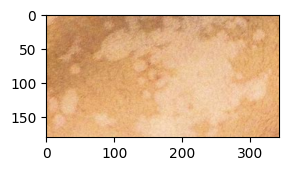

In [8]:
#Perintah untuk memvisualisasikan satu gambar dari data train
image = imread("Data/image/train/Panu/Panu (10).jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [9]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
IMAGE_SIZE = 224
BATCH_SIZE = 128
base_dir = os.path.join('Data/image/train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['Kadas', 'Kudis', 'Panu']

for i,label in enumerate(labels):
    folder = os.path.join("Data/image/test", label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)

        image = imread(image_path)/255.
        image = resize(image,(244,244))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
    break
print("Bentuk array dari dataset Train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
    break
print("Bentuk array dari dataset validation (validasi) adalah", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset Test (pengujian) adalah", X_test.shape,y_test.shape)

Found 102 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Bentuk array dari dataset Train (pelatihan) adalah: (102, 224, 224, 3) (102, 3)
Bentuk array dari dataset validation (validasi) adalah (24, 224, 224, 3) (24, 3)
Bentuk array dari dataset Test (pengujian) adalah (24, 244, 244, 3) (24,)


Menyimpan Label

In [10]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
    f.write(labels_txt)

{'Kadas': 0, 'Kudis': 1, 'Panu': 2}


In [11]:
!cat labels.txt

Kadas
Kudis
Panu

Membuat Model dari Jaringan CNN yang Sudah dipelajari sebelumnya (pre-trained convnets)

In [12]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model Resnet
base_model = tf.keras.applications.ResNet152V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

234545216/234545216 [==============================] - 1s 0us/step


Feature Extraction

In [13]:
base_model.trainable = False
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                        

Mengelompokkan Klasifikasi Tiga Jenis Penyakit Kulit dengan Deep Learning (Convolutional Neural Network)

In [14]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split


Mempersiapkan Data Pengujian

In [15]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

In [16]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          589856    
                                                                 
 global_average_pooling2d (  (None, 32)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 58921603 (224.77 MB)
Trainable params: 589955 (2.25 MB)
Non-trainable params: 58331648 (222.52 MB)
_________________________________________________________________


Pelatihan

In [17]:
history = model.fit_generator(train_generator,
                              epochs=20,
                              validation_data=val_generator)

<ipython-input-17-43612d2b8c6a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/20
1/1 [==============================] - 15s 15s/step - loss: 1.8986 - acc: 0.4118 - val_loss: 3.3179 - val_acc: 0.3333
Epoch 2/20
1/1 [==============================] - 4s 4s/step - loss: 2.6077 - acc: 0.4510 - val_loss: 1.3491 - val_acc: 0.7083
Epoch 3/20
1/1 [==============================] - 4s 4s/step - loss: 1.0413 - acc: 0.6961 - val_loss: 0.6098 - val_acc: 0.8750
Epoch 4/20
1/1 [==============================] - 4s 4s/step - loss: 0.4329 - acc: 0.8529 - val_loss: 0.2123 - val_acc: 0.9167
Epoch 5/20
1/1 [==============================] - 4s 4s/step - loss: 0.1553 - acc: 0.9314 - val_loss: 0.2117 - val_acc: 0.9583
Epoch 6/20
1/1 [==============================] - 4s 4s/step - loss: 0.1908 - acc: 0.9216 - val_loss: 0.2820 - val_acc: 0.7917
Epoch 7/20
1/1 [==============================] - 5s 5s/step - loss: 0.1865 - acc: 0.9020 - val_loss: 0.2591 - val_acc: 0.7917
Epoch 8/20
1/1 [==============================] - 4s 4s/step - loss: 0.1179 - acc: 0.9412 - val_loss: 0.2418 

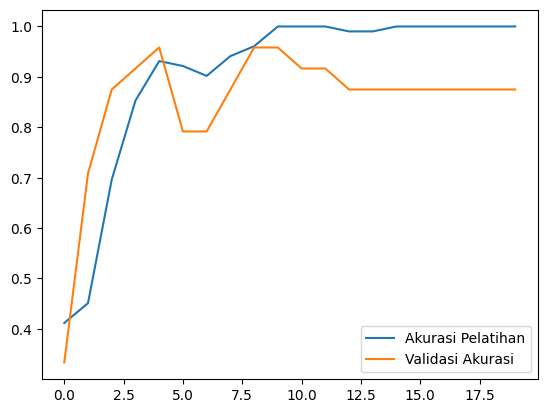

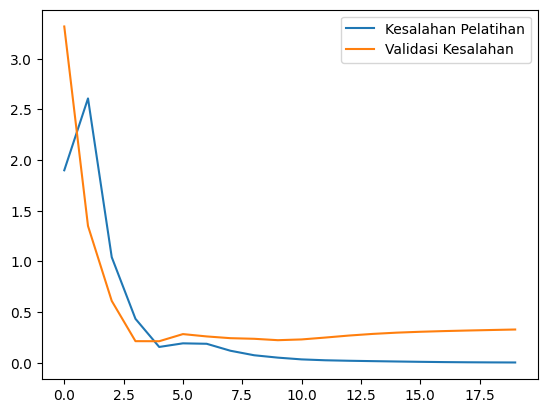

In [18]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

In [19]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


Menggunakan Model

In [20]:
print(train_generator)

In [21]:
#Prediksi Label Validasi dengan Pelatihan
n = 21
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah:", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah", predictions[0])

Labelnya adalah: [0. 1. 0.]
1/1 [==============================] - 3s 3s/step
Prediksinya adalah [0.08483108 0.859273   0.05589591]


Evaluasi

In [22]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3))

['loss', 'acc']
1/1 [==============================] - 1s 944ms/step - loss: 0.1099 - acc: 0.9583
[0.10992205142974854, 0.9583333134651184]


In [23]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

1/1 [==============================] - 3s 3s/step
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2]


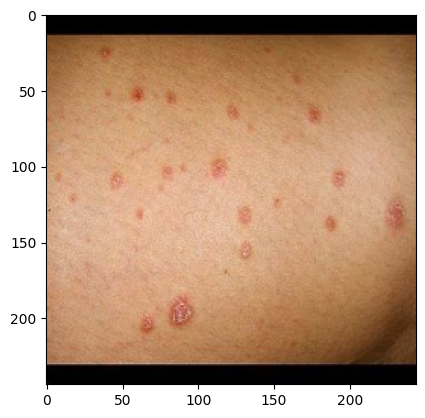

Label yang benar adalah: 1 : Kudis
1/1 [==============================] - 0s 199ms/step
Nilai yang diprediksi adalah: [1.0170428e-05 9.9979860e-01 1.9124839e-04]
Label yang diprediksi adalah: 1 : Kudis
Prediksi benar


In [26]:
n = 10 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2, axis=1)[n]
print("Label yang benar adalah:",true_label, ":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   1.   0.  ]
 [0.   0.12 0.88]]
              precision    recall  f1-score   support

       Kadas       1.00      1.00      1.00         8
       Kudis       0.89      1.00      0.94         8
        Panu       1.00      0.88      0.93         8

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24



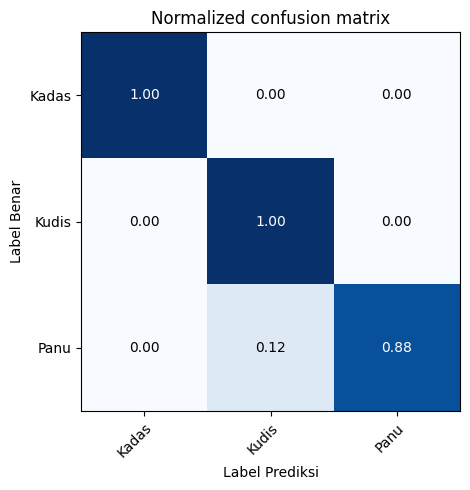

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This fuction prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title + 'Confusion matrix, without normalization'

    #Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    #Only use the labels that appear in the data
    #classes = classes [unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print ("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
          # ... and label them with the respective list entries
          xticklabels=classes, yticklabels=classes,
          title=title,
          ylabel='Label Benar',
          xlabel='Label Prediksi')

    # Rotate the tick labels and set their aligment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

print(classification_report(y_true, y_pred, target_names=labels))